**CITATION: Some of the code are referenced from the EECE571 Assignment2. The codes are for the functionality of training visualization, preprocessing.**

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import seaborn as sns
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import regularizers
from keras.models import Sequential

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import opendatasets as od
import pandas

# Kaggle requires registration to get username and password
od.download("https://www.kaggle.com/datasets/jangedoo/utkface-new/code?datasetId=44109&sortBy=voteCount")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: weiya818
Your Kaggle Key: ··········


100%|██████████| 331M/331M [00:11<00:00, 29.5MB/s]


In [6]:
#Referenced from EECE571T Assignment
# a function to move tensors from the CPU to the GPU and vice versa
def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        new[k] = v.to(device)
    return new

def move_to_cuda(x):
  x_cuda = tuple([torch.from_numpy(arr).cuda() for arr in x])
  return x_cuda

# a function to make gray-scale images the same shape as color images
def gray_to_color(x):
    return x.repeat(3, 1, 1)

# a function to plot a batch of images together
def plot_images(img, ax):
    img = torchvision.utils.make_grid(img)
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))  

In [7]:
data_dir = "/content/utkface-new/UTKFace" #passing the path with training images
files = os.listdir(data_dir)
size = len(files)
print(size)
img_size=48

23708


In [8]:
path = Path("/content/utkface-new/UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

image_path = []
ages = []
genders = []
races= []

np.random.seed(10)
np.random.shuffle(filenames)

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    ages.append(temp[0])
    genders.append(temp[1])
    try:
      races.append(int(temp[2]))
    except:
      races.append(4)

print(len(filenames))
print(filenames[:1])

23708
['50_0_3_20170119204347415.jpg.chip.jpg']


In [9]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race'] = image_path, ages, genders, races
df

,image,age,gender,race
0,50_0_3_20170119204347415.jpg.chip.jpg,50,0,3
1,70_0_0_20170117173731439.jpg.chip.jpg,70,0,0
2,40_0_2_20170116222954442.jpg.chip.jpg,40,0,2
3,70_0_0_20170116233001019.jpg.chip.jpg,70,0,0
4,54_0_0_20170113210127075.jpg.chip.jpg,54,0,0
...,...,...,...,...
23703,28_1_4_20170117202452072.jpg.chip.jpg,28,1,4
23704,27_0_0_20170117175803620.jpg.chip.jpg,27,0,0
23705,8_1_1_20170116153005352.jpg.chip.jpg,8,1,1
23706,8_1_0_20170109203429413.jpg.chip.jpg,8,1,0


In [10]:
gender_dict = {0:"Male",1:"Female"}
race_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}
df = df.astype({'age':'float32', 'gender': 'int32', 'race': 'int32'})

<ipython-input-11-0ae266fa9606>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age,kde=True, bins=30)


<Axes: xlabel='age', ylabel='Density'>

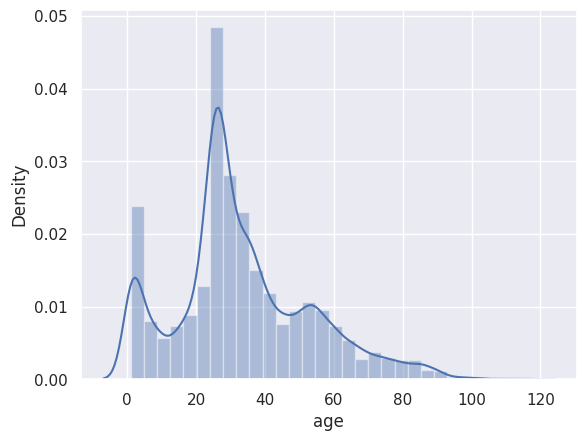

In [11]:
# sns.distplot(df.age)
sns.set_theme()
sns.distplot(df.age,kde=True, bins=30)

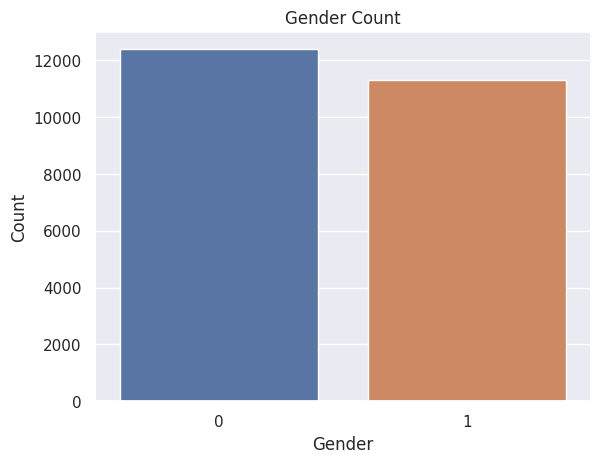

In [12]:
sns.countplot(x='gender', data=df)
plt.title('Gender Count')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

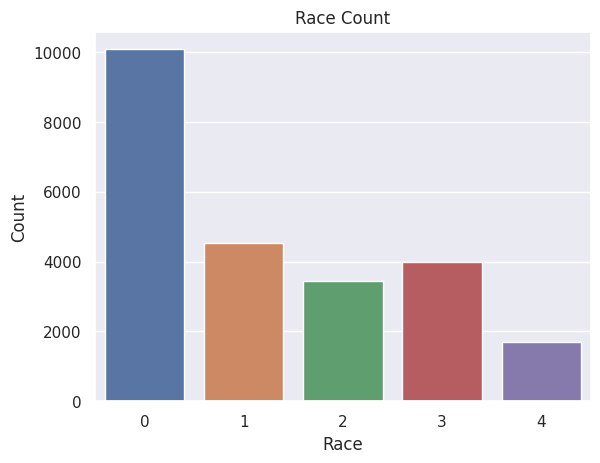

In [13]:
sns.countplot(x='race', data=df)
plt.title('Race Count')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

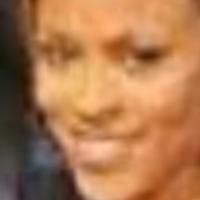

54.0
0
0


In [14]:
# Define the file path of the image
image_file_path = "/content/utkface-new/UTKFace/"
image = Image.open(image_file_path +df.image[4])
image.show()
print(df.age[4])
print(df.gender[4])
print(df.race[4])

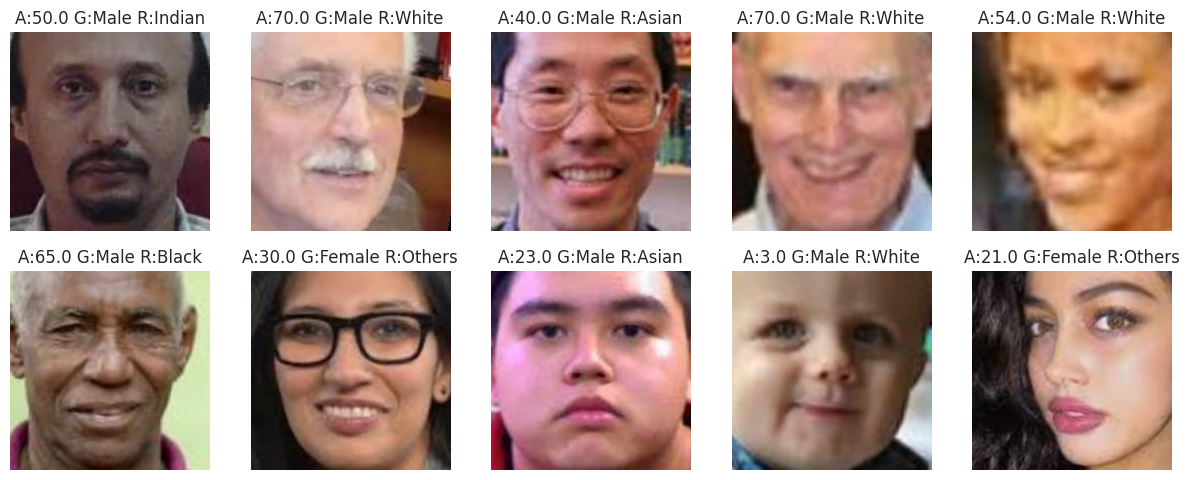

In [15]:
plt.figure(figsize=(15,15))
files = df.iloc[0:10]

for index, image_file, age, gender, race in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("/content/utkface-new/UTKFace/"+image_file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"A:{age} G:{gender_dict[gender]} R:{race_dict[race]}")
    plt.axis('off')

In [17]:
x = []
for i in range(len(df)):
    file = df['image'].iloc[i]
    # grayscale=True
    img = load_img("/content/utkface-new/UTKFace/"+file)
    img = img.resize((64,64), Image.ANTIALIAS)
    img = np.array(img)
    x.append(img)

x = np.array(x)
x = x.reshape(len(x), 64, 64, 3)

In [18]:
y_age = df['age']
y_gender = df['gender']
y_race = df['race']

In [19]:
x = x/255.

In [20]:
#only cares about age info here
train_data, remain_data, y_train, y_remain = train_test_split(x, y_age, test_size=0.3, random_state=42)

val_data, test_data, y_val, y_test = train_test_split(remain_data, y_remain, test_size=0.5, random_state=42)

In [21]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(16595, 64, 64, 3)
(3556, 64, 64, 3)
(3557, 64, 64, 3)


In [22]:
# train_datagen = ImageDataGenerator(
#       width_shift_range = 0.1, height_shift_range = 0.1,  rescale=1./255., horizontal_flip = True)

# val_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
      width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_iter = train_datagen.flow(train_data, y_train, batch_size=32)
val_iter = val_datagen.flow(val_data, y_val, batch_size=32, 
    shuffle=False)
test_iter = test_datagen.flow(test_data, y_test, batch_size=32)

# **Transfer Learning**

In [23]:
pip install keras_vggface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
pip install keras-applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00


In [ ]:
# Transfer learning from the VGG16 Net
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


# Create a MirroredStrategy for distributing training across multiple GPUs
strategy = tf.distribute.MirroredStrategy()

# Inside the strategy.scope() block, define and compile your model
with strategy.scope():

  # Load the VGGFace model
  vggface_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

  # Add custom top layers for age prediction
  x = vggface_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dense(256, activation='relu')(x)
  x = Dense(256, activation='relu')(x)
  predictions = Dense(1, activation='linear')(x)

  # Create the transfer learning model
  model = Model(inputs=vggface_model.input, outputs=predictions)

  # Freeze the layers of the VGGFace model
  for layer in vggface_model.layers:
      layer.trainable = False

  # Compile the model
  optimizer = Adam(lr=0.001)
  model.compile(optimizer=optimizer, loss='mape')


# Train the model
model.fit_generator(train_iter, steps_per_epoch=len(train_iter), epochs=10, validation_data=val_iter, validation_steps=len(val_iter))

# After training, you can use the trained model for age prediction on new images


58889256/58889256 [==============================] - 1s 0us/step


<ipython-input-23-e7968b495581>:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_iter, steps_per_epoch=len(train_iter), epochs=10, validation_data=val_iter, validation_steps=len(val_iter))


Epoch 1/10
519/519 [==============================] - 55s 90ms/step - loss: 53.4337 - val_loss: 44.8837
Epoch 2/10
519/519 [==============================] - 27s 51ms/step - loss: 45.8560 - val_loss: 45.4752
Epoch 3/10
519/519 [==============================] - 27s 52ms/step - loss: 43.9329 - val_loss: 44.3670
Epoch 4/10
519/519 [==============================] - 27s 52ms/step - loss: 41.2925 - val_loss: 40.8022
Epoch 5/10
519/519 [==============================] - 26s 50ms/step - loss: 40.9871 - val_loss: 39.3014
Epoch 6/10
519/519 [==============================] - 27s 51ms/step - loss: 39.6752 - val_loss: 38.5358
Epoch 7/10
519/519 [==============================] - 27s 52ms/step - loss: 38.5746 - val_loss: 37.9794
Epoch 8/10
519/519 [==============================] - 28s 54ms/step - loss: 38.4643 - val_loss: 40.6637
Epoch 9/10
519/519 [==============================] - 26s 51ms/step - loss: 37.6295 - val_loss: 37.1949
Epoch 10/10
519/519 [==============================] - 27s 51ms/

In [ ]:
model.fit_generator(train_iter, steps_per_epoch=len(train_iter), epochs=10, validation_data=val_iter, validation_steps=len(val_iter))

In [ ]:
def get_tf_accuracy(network, data_loader, threshold=0.1):
    iterator = iter(data_loader)    
    correct = 0
    total = 0
    for i in range(len(iterator)):        
        batch_gpu = next(iterator)
        # batch_gpu = move_to_cuda(batch_cpu)
        image = batch_gpu[0]
        pred = network.predict(image) 
        pred = pred.squeeze()
        ground_truth = batch_gpu[1].squeeze()  # Assuming batch_gpu[1] contains ground truth ages
       
        # Calculate accuracy as percentage of predictions within threshold
        # accuracy = ((pred - ground_truth).abs() <= threshold).sum().item() / pred.shape[0]
        accuracy = (np.abs(pred - ground_truth) <= (threshold*ground_truth)).sum().item()     
        correct += accuracy       
        total += pred.shape[0]

        # total += pred.shape[0]
    print(pred)
    print(ground_truth)       
    return correct / total

In [ ]:
# predictions = model.predict_generator(val_iter, steps=len(val_iter))
# print(predictions)
# ts_batch = next(val_iter)
# pred = model.predict(ts_batch[0])
# print(pred)
# print(ts_batch[1])
print(get_tf_accuracy(model, val_iter))

1/1 [==============================] - 0s 71ms/step
[27.610943 55.268967 34.375526 31.767345]
[35. 38. 36. 32.]
0.22778402699662542


# **Customized CNN**

In [33]:
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input


# Create a MirroredStrategy for distributing training across multiple GPUs
strategy = tf.distribute.MirroredStrategy()
# Inside the strategy.scope() block, define and compile your model
with strategy.scope():
  #Version2-testacc:64.6%
  input = Input(shape=(64,64,3))
  conv1 = Conv2D(128,(3,3),activation="relu")(input)
  batch1 = BatchNormalization()(conv1)
  pool1 = MaxPool2D((2,2))(batch1)
  conv2 = Conv2D(256,(3,3),activation="relu")(pool1)
  batch2 = BatchNormalization()(conv2)
  pool2 = MaxPool2D((2,2))(batch2)
  conv3 = Conv2D(512,(3,3),activation="relu")(pool2)
  batch3 = BatchNormalization()(conv3)
  pool3 = MaxPool2D((2,2))(batch3)
  flt = Flatten()(pool3)
  #age
  age_l = Dense(128,activation="relu")(flt)
  age_l = Dense(64,activation="relu")(age_l)
  age_l = Dense(32,activation="relu")(age_l)
  # age_l = Dropout(0.3)(age_l)
  age_l = Dense(1,activation="relu", name = "age")(age_l)



  model = Model(inputs=input,outputs=[age_l])
  model.compile(optimizer=Adam(lr=0.001), loss='mape', metrics='mse')
  model.fit(x=train_data, y=y_train, batch_size=32, epochs=10, validation_data=(val_data, y_val))

Epoch 1/10
519/519 [==============================] - 18s 27ms/step - loss: 61.2004 - mse: 591.8822 - val_loss: 51.6522 - val_mse: 412.6497
Epoch 2/10
519/519 [==============================] - 13s 26ms/step - loss: 47.7378 - mse: 396.5630 - val_loss: 63.4296 - val_mse: 328.1458
Epoch 3/10
519/519 [==============================] - 13s 25ms/step - loss: 43.2454 - mse: 323.7517 - val_loss: 44.1738 - val_mse: 421.1728
Epoch 4/10
519/519 [==============================] - 13s 25ms/step - loss: 40.7635 - mse: 277.7986 - val_loss: 54.1854 - val_mse: 223.2486
Epoch 5/10
519/519 [==============================] - 13s 25ms/step - loss: 36.7506 - mse: 226.9098 - val_loss: 37.9716 - val_mse: 285.8107
Epoch 6/10
519/519 [==============================] - 13s 25ms/step - loss: 31.1449 - mse: 185.5843 - val_loss: 35.5587 - val_mse: 350.8763
Epoch 7/10
519/519 [==============================] - 13s 25ms/step - loss: 26.1931 - mse: 148.5856 - val_loss: 31.8828 - val_mse: 328.9186
Epoch 8/10
519/519 [

In [26]:
from keras.models import load_model,Model
model = load_model('/content/drive/MyDrive/EECE570/Age_model_2/CNN_model_singletask_reg.h5')

In [32]:
# print(get_tf_accuracy(model, train_iter))
# print(np.array(y_train))
prediction = np.squeeze(model.predict(test_data))
accuracy = (np.abs(prediction - np.array(y_test)) <= (0.2*np.array(y_test))).sum().item()/ np.array(y_test).shape[0]
print(accuracy)

112/112 [==============================] - 1s 7ms/step
0.4599381501265111


In [ ]:
model.save('/content/drive/MyDrive/EECE570/Age_model_2/CNN_model_singletask_reg2.h5')

# **Customized CNN classification**

In [ ]:
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from keras.utils import to_categorical

# Create a MirroredStrategy for distributing training across multiple GPUs
strategy = tf.distribute.MirroredStrategy()
# Inside the strategy.scope() block, define and compile your model
with strategy.scope():
  #Version2-testacc:64.6%
  input = Input(shape=(64,64,3))
  conv1 = Conv2D(128,(3,3),activation="relu")(input)
  batch1 = BatchNormalization()(conv1)
  pool1 = MaxPool2D((2,2))(batch1)
  conv2 = Conv2D(256,(3,3),activation="relu")(pool1)
  batch2 = BatchNormalization()(conv2)
  pool2 = MaxPool2D((2,2))(batch2)
  conv3 = Conv2D(512,(3,3),activation="relu")(pool2)
  batch3 = BatchNormalization()(conv3)
  pool3 = MaxPool2D((2,2))(batch3)
  flt = Flatten()(pool3)
  #age
  age_l = Dense(256,activation="relu")(flt)
  # age_l = Dropout(0.2)(age_l)
  # age_l = Dense(256,activation="relu")(age_l)
  age_l = Dense(256,activation="relu")(age_l)
  # age_l = Dropout(0.2)(age_l)
  age_l = Dense(128,activation="softmax", name = "age")(age_l)

  y_age_train_categorical = to_categorical(y_train, num_classes=128)
  y_age_val_categorical = to_categorical(y_val, num_classes=128)

  model = Model(inputs=input,outputs=[age_l])
  model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics='accuracy')
  model.fit(x=train_data, y=y_age_train_categorical , batch_size=32, epochs=60, validation_data=(val_data, y_age_val_categorical ))

Epoch 1/60
519/519 [==============================] - 17s 26ms/step - loss: 3.9548 - accuracy: 0.1132 - val_loss: 3.7758 - val_accuracy: 0.1085
Epoch 2/60
519/519 [==============================] - 13s 25ms/step - loss: 3.4614 - accuracy: 0.1444 - val_loss: 3.4744 - val_accuracy: 0.1417
Epoch 3/60
519/519 [==============================] - 13s 24ms/step - loss: 3.2766 - accuracy: 0.1567 - val_loss: 3.2850 - val_accuracy: 0.1499
Epoch 4/60
519/519 [==============================] - 13s 25ms/step - loss: 3.1593 - accuracy: 0.1637 - val_loss: 3.4329 - val_accuracy: 0.1386
Epoch 5/60
519/519 [==============================] - 13s 25ms/step - loss: 3.0745 - accuracy: 0.1725 - val_loss: 3.4671 - val_accuracy: 0.1381
Epoch 6/60
519/519 [==============================] - 13s 25ms/step - loss: 2.9944 - accuracy: 0.1804 - val_loss: 3.4875 - val_accuracy: 0.1246
Epoch 7/60
519/519 [==============================] - 13s 25ms/step - loss: 2.9097 - accuracy: 0.1891 - val_loss: 3.2050 - val_accuracy:

In [ ]:
  model.fit(x=train_data, y=y_age_train_categorical , batch_size=32, epochs=10, validation_data=(val_data, y_age_val_categorical ))

In [ ]:
predictions = model.predict(test_data)
predictions = np.argmax(predictions, axis=1)
print(predictions)
print(y_test)
accuracy = (np.abs(predictions-y_test) <= 0.5*y_test).sum().item()/ predictions.shape[0]
print(accuracy)

112/112 [==============================] - 1s 7ms/step
[26 70 66 ... 32 70 29]
4143     23.0
21432    67.0
11060    65.0
18183    40.0
6225     35.0
         ... 
21408     4.0
2043      3.0
20620    42.0
4371     72.0
274      32.0
Name: age, Length: 3557, dtype: float32
0.9173460781557492


In [ ]:
model.save('/content/drive/MyDrive/EECE570/Age_model_2/CNN_model_singletask_classification.h5')

# **Multi-task CNN**

In [36]:
#Introducing three target data and split them into train, validation, test sets
mt_train_data, mt_remain_data, mt_y_age_train, mt_y_age_remain = train_test_split(x, y_age, test_size=0.3, random_state=42)
mt_val_data, mt_test_data, mt_y_age_val, mt_y_age_test = train_test_split(mt_remain_data, mt_y_age_remain, test_size=0.5, random_state=42)

mt_train_data, mt_remain_data, mt_y_race_train, mt_y_race_remain = train_test_split(x, y_race, test_size=0.3, random_state=42)
mt_val_data, mt_test_data, mt_y_race_val, mt_y_race_test = train_test_split(mt_remain_data, mt_y_race_remain, test_size=0.5, random_state=42)

mt_train_data, mt_remain_data, mt_y_gender_train, mt_y_gender_remain = train_test_split(x, y_gender, test_size=0.3, random_state=42)
mt_val_data, mt_test_data, mt_y_gender_val, mt_y_gender_test = train_test_split(mt_remain_data, mt_y_gender_remain, test_size=0.5, random_state=42)

In [ ]:
print(np.array(mt_y_age_train).reshape(-1, 1).shape)

(16595, 1)


In [37]:
# Concatenate age gender, and race targets for training set
mt_y_train = np.concatenate([np.array(mt_y_age_train).reshape(-1, 1), np.array(mt_y_race_train).reshape(-1, 1), np.array(mt_y_gender_train).reshape(-1, 1)], axis=1)

# Create data generators for training set with multiple targets
mt_train_iter = train_datagen.flow(mt_train_data, mt_y_train, batch_size=32, shuffle=False)
# print(type(next(mt_train_iter)))
# print(next(mt_train_iter))
# mt_train_iter = train_datagen.flow(mt_train_data, mt_y_gender_train, batch_size=32)

# Concatenate age gender and race targets for validation set
mt_y_val = np.concatenate([np.array(mt_y_age_val).reshape(-1, 1), np.array(mt_y_race_val).reshape(-1, 1), np.array(mt_y_gender_val).reshape(-1, 1)], axis=1)

# Create data generators for validation set with multiple targets
mt_val_iter = val_datagen.flow(mt_val_data, mt_y_val, batch_size=32, shuffle=False)
# mt_val_iter = val_datagen.flow(mt_val_data, mt_y_gender_val, batch_size=32, shuffle=False)

# Concatenate age gender and race targets for test set
mt_y_test = np.concatenate([np.array(mt_y_age_test).reshape(-1, 1), np.array(mt_y_race_test).reshape(-1, 1), np.array(mt_y_gender_test).reshape(-1, 1)], axis=1)

# Create data generators for test set with multiple targets
mt_test_iter = test_datagen.flow(mt_test_data, mt_y_test, batch_size=32)

In [ ]:
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from keras.utils import to_categorical
import keras.backend as K

# Create a MirroredStrategy for distributing training across multiple GPUs
strategy = tf.distribute.MirroredStrategy()
# Inside the strategy.scope() block, define and compile your model
with strategy.scope():
  #Version2-acc:62.55% 78.3% 89.4%
  input = Input(shape=(64,64,3))
  conv1 = Conv2D(128,(3,3),activation="relu")(input)
  batch1 = BatchNormalization(axis = 3)(conv1)
  pool1 = MaxPool2D((2,2))(batch1)
  conv2 = Conv2D(256,(3,3),activation="relu")(pool1)
  batch2 = BatchNormalization(axis = 3)(conv2)
  pool2 = MaxPool2D((2,2))(batch2)
  conv3 = Conv2D(512,(3,3),activation="relu")(pool2)
  batch3 = BatchNormalization(axis = 3)(conv3)
  pool3 = MaxPool2D((2,2))(batch3)
  flt = Flatten()(pool3)


  age = Dense(128,activation="relu")(flt)
  age = Dense(64,activation="relu")(age)
  age = Dense(32,activation="relu")(age)
  # age = Dropout(0.1)(age)
  age = Dense(1,activation="relu", name='age')(age)

  race = Dense(128, activation="sigmoid")(flt)
  race = Dense(64,activation="sigmoid")(race)
  # race = Dropout(0.1)(race)
  race = Dense(5, activation="softmax", name='race')(race)  # Update with the correct number of classes


  gender = Dense(128, activation="sigmoid")(flt)
  gender = Dense(64,activation="sigmoid")(gender)
  # gender = Dropout(0.1)(gender)
  gender = Dense(1,activation="sigmoid", name='gender')(gender)


      # Convert race labels into categorical format
  mt_y_race_train_categorical = to_categorical(mt_y_race_train, num_classes=5)
  mt_y_race_val_categorical = to_categorical(mt_y_race_val, num_classes=5)

  model = Model(inputs=input,outputs=[age, race, gender])
  model.compile(optimizer='adam',loss={'age':'mape','race':'categorical_crossentropy', 'gender':'binary_crossentropy'},loss_weights={'age':1.0 ,'race':1.0, 'gender':1.0},metrics={'age':'mse','race':'accuracy','gender':'accuracy'})
  # model.fit(mt_train_iter, steps_per_epoch=len(mt_train_iter), epochs=10, validation_data=mt_val_iter, validation_steps=len(mt_val_iter))

  model.fit(x=mt_train_data, y=[mt_y_age_train, mt_y_race_train_categorical, mt_y_gender_train], batch_size=32, epochs=60, validation_data=(mt_val_data, [mt_y_age_val, mt_y_race_val_categorical, mt_y_gender_val]))

Epoch 1/60
519/519 [==============================] - 20s 29ms/step - loss: 57.6740 - age_loss: 56.0426 - race_loss: 1.1646 - gender_loss: 0.4667 - age_mse: 516.6810 - race_accuracy: 0.5550 - gender_accuracy: 0.7841 - val_loss: 52.3449 - val_age_loss: 50.7922 - val_race_loss: 1.1104 - val_gender_loss: 0.4423 - val_age_mse: 441.1049 - val_race_accuracy: 0.5650 - val_gender_accuracy: 0.7874
Epoch 2/60
519/519 [==============================] - 14s 27ms/step - loss: 47.2184 - age_loss: 45.7735 - race_loss: 1.0390 - gender_loss: 0.4060 - age_mse: 367.8313 - race_accuracy: 0.6097 - gender_accuracy: 0.8142 - val_loss: 52.4384 - val_age_loss: 51.0022 - val_race_loss: 1.0449 - val_gender_loss: 0.3913 - val_age_mse: 512.1945 - val_race_accuracy: 0.5942 - val_gender_accuracy: 0.8166
Epoch 3/60
519/519 [==============================] - 14s 27ms/step - loss: 42.4505 - age_loss: 41.0932 - race_loss: 0.9813 - gender_loss: 0.3760 - age_mse: 282.6151 - race_accuracy: 0.6339 - gender_accuracy: 0.8283 

In [ ]:
model.save('/content/drive/MyDrive/EECE570/Age_model_2/CNN_model_multitask_reg.h5')

In [34]:
from keras.models import load_model,Model
model = load_model('/content/drive/MyDrive/EECE570/Age_model_2/CNN_model_multitask_reg.h5')

In [38]:
from keras.utils import to_categorical
mt_y_race_train_categorical = to_categorical(mt_y_race_train, num_classes=5)
mt_y_race_val_categorical = to_categorical(mt_y_race_val, num_classes=5)
model.fit(x=mt_train_data, y=[mt_y_age_train, mt_y_race_train_categorical, mt_y_gender_train], batch_size=32, epochs=10, validation_data=(mt_val_data, [mt_y_age_val, mt_y_race_val_categorical, mt_y_gender_val]))

Epoch 1/10
519/519 [==============================] - 19s 28ms/step - loss: 11.6663 - age_loss: 11.1054 - race_loss: 0.4038 - gender_loss: 0.1571 - age_mse: 28.8749 - race_accuracy: 0.8738 - gender_accuracy: 0.9417 - val_loss: 15.1099 - val_age_loss: 14.4374 - val_race_loss: 0.4940 - val_gender_loss: 0.1784 - val_age_mse: 38.1826 - val_race_accuracy: 0.8363 - val_gender_accuracy: 0.9319
Epoch 2/10
519/519 [==============================] - 14s 27ms/step - loss: 10.0452 - age_loss: 9.5526 - race_loss: 0.3547 - gender_loss: 0.1379 - age_mse: 22.9213 - race_accuracy: 0.8849 - gender_accuracy: 0.9473 - val_loss: 11.2867 - val_age_loss: 10.7127 - val_race_loss: 0.4153 - val_gender_loss: 0.1586 - val_age_mse: 31.7602 - val_race_accuracy: 0.8633 - val_gender_accuracy: 0.9435
Epoch 3/10
519/519 [==============================] - 14s 27ms/step - loss: 8.9854 - age_loss: 8.5219 - race_loss: 0.3340 - gender_loss: 0.1295 - age_mse: 19.2754 - race_accuracy: 0.8906 - gender_accuracy: 0.9525 - val_lo

In [ ]:
def get_mt_accuracy(network, data_loader, threshold=0.5):
    iterator = iter(data_loader)    
    age_correct = 0
    race_correct = 0
    gender_correct = 0
    total = 0
    for i in range(len(iterator)):        
        batch = next(iterator)
        image = batch[0]
        pred = network.predict(image)
        # age
        age_pred = pred[0]
        age_pred = age_pred.squeeze()
        age_ground_truth = batch[1][:,0] 
        age_accuracy = (np.abs(age_pred - age_ground_truth) <= (threshold*age_ground_truth)).sum().item()     
        age_correct += age_accuracy 
        #race
        race_pred = pred[1]
        race_pred = np.argmax(race_pred, axis=1)
        race_ground_truth = batch[1][:,1]
        race_accuracy = (race_pred == race_ground_truth).sum().item()
        race_correct += race_accuracy
        


        # gender
        gender_pred = pred[2]
        gender_pred = np.round(gender_pred.squeeze())
        gender_ground_truth = batch[1][:,2]
        gender_accuracy = (gender_pred == gender_ground_truth).sum().item()
        gender_correct += gender_accuracy     


        total += pred[0].shape[0]
    # print(race_pred)
    print(age_pred)
    print(gender_pred)
    print(batch[1])       
    return {"Age accuracy":age_correct / total, "Race accuracy": race_correct/total,"Gender accuracy": gender_correct/total}

In [ ]:
print(get_mt_accuracy(model, mt_test_iter))

1/1 [==============================] - 0s 68ms/step
[32.02168   24.055935   2.1625915 32.443462  24.473557 ]
[1. 1. 1. 0. 1.]
[[38.  3.  1.]
 [24.  1.  1.]
 [ 4.  2.  1.]
 [34.  1.  0.]
 [30.  2.  1.]]
{'Age accuracy': 0.9395558054540343, 'Race accuracy': 0.7708743323025021, 'Gender accuracy': 0.888107956142817}


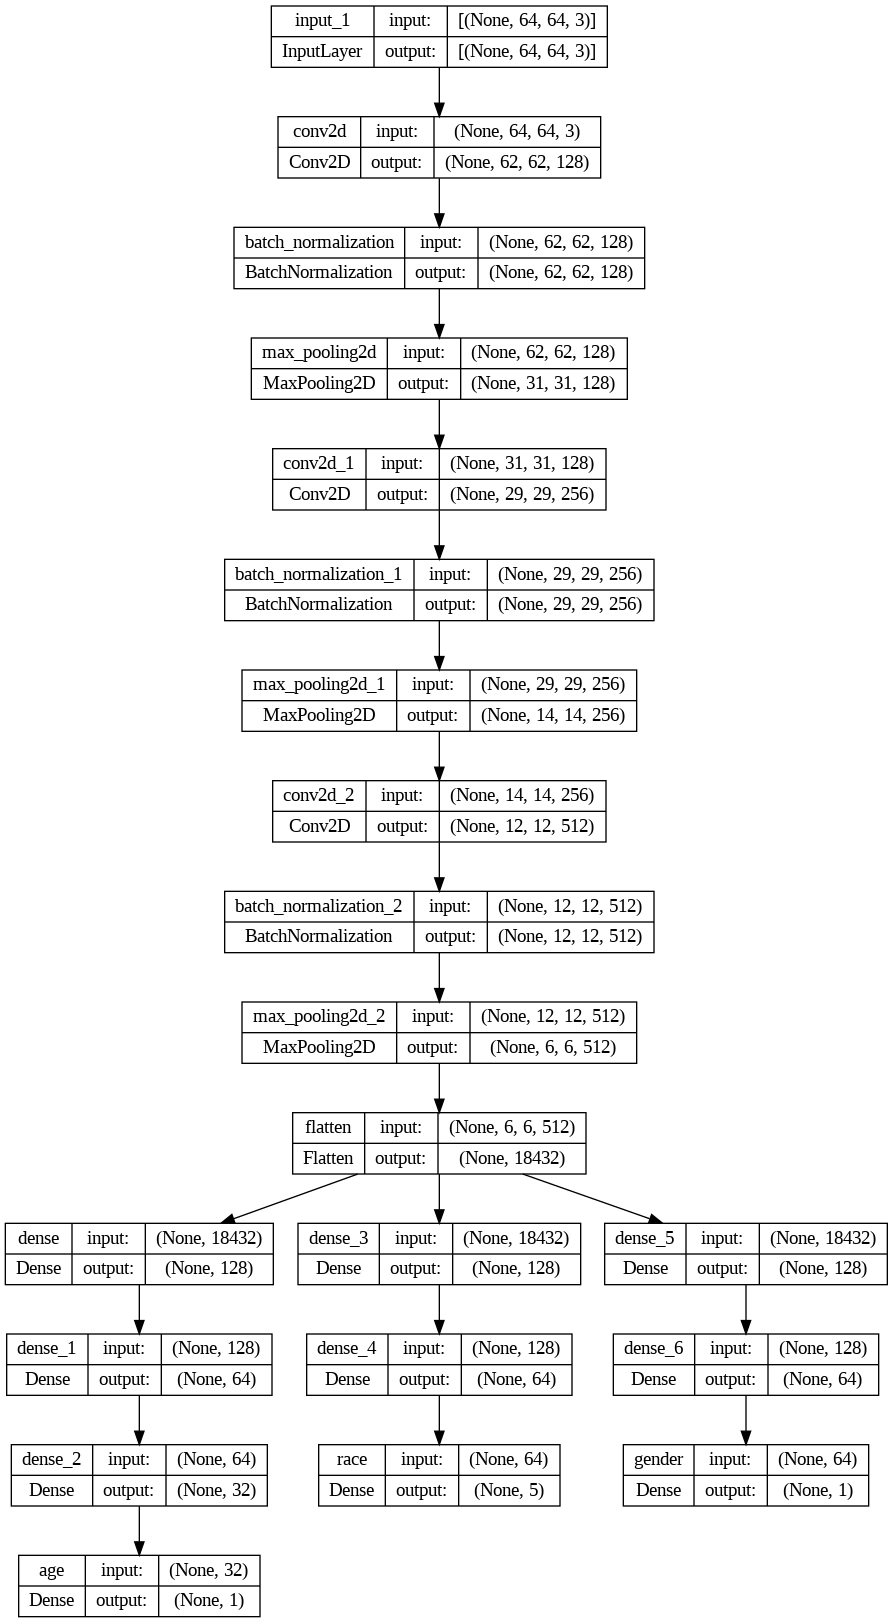

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True)

# **Multi Stage**

In [39]:
#Train a CNN model that predicts race
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from keras.utils import to_categorical

# Create a MirroredStrategy for distributing training across multiple GPUs
strategy = tf.distribute.MirroredStrategy()
# Inside the strategy.scope() block, define and compile your model
with strategy.scope():
  input = Input(shape=(64,64,3))
  conv1 = Conv2D(128,(3,3),activation="relu")(input)
  batch1 = BatchNormalization()(conv1)
  pool1 = MaxPool2D((2,2))(batch1)
  conv2 = Conv2D(256,(3,3),activation="relu")(pool1)
  batch2 = BatchNormalization()(conv2)
  pool2 = MaxPool2D((2,2))(batch2)
  conv3 = Conv2D(512,(3,3),activation="relu")(pool2)
  batch3 = BatchNormalization()(conv3)
  pool3 = MaxPool2D((2,2))(batch3)
  flt = Flatten()(pool3)

  race = Dense(128, activation="sigmoid")(flt)
  race = Dense(64,activation="sigmoid")(race)
  race = Dropout(0.2)(race)
  race = Dense(5, activation="softmax", name='race')(race)  # Update with the correct number of classes

  mt_y_race_train_categorical = to_categorical(mt_y_race_train, num_classes=5)
  mt_y_race_val_categorical = to_categorical(mt_y_race_val, num_classes=5)


  model = Model(inputs=input,outputs=[race])
  model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics='accuracy')
  model.fit(x=mt_train_data, y=mt_y_race_train_categorical, batch_size=32, epochs=25, validation_data=(mt_val_data, mt_y_race_val_categorical))

Epoch 1/25
519/519 [==============================] - 18s 28ms/step - loss: 1.1229 - accuracy: 0.5770 - val_loss: 1.0421 - val_accuracy: 0.6122
Epoch 2/25
519/519 [==============================] - 14s 26ms/step - loss: 0.8939 - accuracy: 0.6760 - val_loss: 0.8649 - val_accuracy: 0.6957
Epoch 3/25
519/519 [==============================] - 13s 25ms/step - loss: 0.8343 - accuracy: 0.7039 - val_loss: 0.8924 - val_accuracy: 0.6789
Epoch 4/25
519/519 [==============================] - 14s 26ms/step - loss: 0.7880 - accuracy: 0.7212 - val_loss: 0.8948 - val_accuracy: 0.6777
Epoch 5/25
519/519 [==============================] - 14s 26ms/step - loss: 0.7579 - accuracy: 0.7337 - val_loss: 0.8460 - val_accuracy: 0.6932
Epoch 6/25
519/519 [==============================] - 13s 25ms/step - loss: 0.7338 - accuracy: 0.7417 - val_loss: 0.7664 - val_accuracy: 0.7202
Epoch 7/25
519/519 [==============================] - 13s 26ms/step - loss: 0.7019 - accuracy: 0.7556 - val_loss: 0.8402 - val_accuracy:

In [ ]:
#Split the training dataset by the labels of race
predictions = model.predict(mt_train_data)
predictions = np.argmax(predictions, axis=1)
accuracy = (predictions == mt_y_race_train).sum().item()/predictions.shape[0]

race0_index = (predictions == 0).nonzero()[0]
race0_x_train = mt_train_data[race0_index]
race0_y_train = np.array(mt_y_age_train).reshape(mt_y_age_train.shape[0],1)[race0_index]

race1_index = (predictions == 1).nonzero()[0]
race1_x_train = mt_train_data[race1_index]
race1_y_train = np.array(mt_y_age_train).reshape(mt_y_age_train.shape[0],1)[race1_index]
print(race1_y_train.shape)

race2_index = (predictions == 2).nonzero()[0]
race2_x_train = mt_train_data[race2_index]
race2_y_train = np.array(mt_y_age_train).reshape(mt_y_age_train.shape[0],1)[race2_index]

race3_index = (predictions == 3).nonzero()[0]
race3_x_train = mt_train_data[race3_index]
race3_y_train = np.array(mt_y_age_train).reshape(mt_y_age_train.shape[0],1)[race3_index]

race4_index = (predictions == 4).nonzero()[0]
race4_x_train = mt_train_data[race4_index]
race4_y_train = np.array(mt_y_age_train).reshape(mt_y_age_train.shape[0],1)[race4_index]


519/519 [==============================] - 4s 7ms/step
(2873, 1)


In [ ]:
#Split the validation dataset by the labels of race
predictions = model.predict(mt_val_data)
predictions = np.argmax(predictions, axis=1)
accuracy = (predictions == mt_y_race_val).sum().item()/predictions.shape[0]
print(accuracy)

race0_index = (predictions == 0).nonzero()[0]
race0_x_val = mt_val_data[race0_index]
race0_y_val = np.array(mt_y_age_val).reshape(mt_y_age_val.shape[0],1)[race0_index]

race1_index = (predictions == 1).nonzero()[0]
race1_x_val = mt_val_data[race1_index]
race1_y_val = np.array(mt_y_age_val).reshape(mt_y_age_val.shape[0],1)[race1_index]
print(race1_y_val.shape)

race2_index = (predictions == 2).nonzero()[0]
race2_x_val = mt_val_data[race2_index]
race2_y_val = np.array(mt_y_age_val).reshape(mt_y_age_val.shape[0],1)[race2_index]

race3_index = (predictions == 3).nonzero()[0]
race3_x_val = mt_val_data[race3_index]
race3_y_val = np.array(mt_y_age_val).reshape(mt_y_age_val.shape[0],1)[race3_index]

race4_index = (predictions == 4).nonzero()[0]
race4_x_val = mt_val_data[race4_index]
race4_y_val = np.array(mt_y_age_val).reshape(mt_y_age_val.shape[0],1)[race4_index]

# fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
# axes = fig.subplots(1, 4)
# image = torch.tensor(race0_x_train)
# result = torch.tensor(race0_y_train)
# image = image.permute(0, 3, 1, 2) 

# for i in range(5, 8):
#   plot_images(image[i], ax=axes[i-5])
#   print(result[i])

112/112 [==============================] - 1s 6ms/step
0.7741844769403825
(622, 1)


In [ ]:
#Split the test dataset by the labels of race
predictions = model.predict(mt_test_data)
predictions = np.argmax(predictions, axis=1)
accuracy = (predictions == mt_y_race_test).sum().item()/predictions.shape[0]
print(accuracy)

race0_index = (predictions == 0).nonzero()[0]
race0_x_test = mt_test_data[race0_index]
race0_y_test = np.array(mt_y_age_test).reshape(mt_y_age_test.shape[0],1)[race0_index]
print(race0_y_test.shape)
race1_index = (predictions == 1).nonzero()[0]
race1_x_test = mt_test_data[race1_index]
race1_y_test = np.array(mt_y_age_test).reshape(mt_y_age_test.shape[0],1)[race1_index]
print(race1_y_test.shape)

race2_index = (predictions == 2).nonzero()[0]
race2_x_test = mt_test_data[race2_index]
race2_y_test = np.array(mt_y_age_test).reshape(mt_y_age_test.shape[0],1)[race2_index]

race3_index = (predictions == 3).nonzero()[0]
race3_x_test = mt_test_data[race3_index]
race3_y_test = np.array(mt_y_age_test).reshape(mt_y_age_test.shape[0],1)[race3_index]

race4_index = (predictions == 4).nonzero()[0]
race4_x_test = mt_test_data[race4_index]
race4_y_test = np.array(mt_y_age_test).reshape(mt_y_age_test.shape[0],1)[race4_index]

112/112 [==============================] - 1s 6ms/step
0.7734045543997751
(1631, 1)
(580, 1)


In [ ]:
# Training submodels that handles each of the race-based dataset
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
# Create a MirroredStrategy for distributing training across multiple GPUs
strategy = tf.distribute.MirroredStrategy()
# Inside the strategy.scope() block, define and compile your model
with strategy.scope():
  #Version2-testacc:62.6%
  input = Input(shape=(64,64,3))
  conv1 = Conv2D(128,(3,3),activation="relu")(input)
  batch1 = BatchNormalization()(conv1)
  pool1 = MaxPool2D((2,2))(batch1)
  conv2 = Conv2D(256,(3,3),activation="relu")(pool1)
  batch2 = BatchNormalization()(conv2)
  pool2 = MaxPool2D((2,2))(batch2)
  conv3 = Conv2D(512,(3,3),activation="relu")(pool2)
  batch3 = BatchNormalization()(conv3)
  pool3 = MaxPool2D((2,2))(batch3)
  flt = Flatten()(pool3)
  #age
  age_l = Dense(128,activation="relu")(flt)
  age_l = Dense(64,activation="relu")(age_l)
  age_l = Dense(32,activation="relu")(age_l)
  # age_l = Dropout(0.2)(age_l)
  age_l = Dense(1,activation="relu", name = "age")(age_l)

  model = Model(inputs=input,outputs=[age_l])
  model.compile(optimizer=Adam(lr=0.001), loss='mape', metrics='mse')
# Change the arguments' name to train for other races
  model.fit(x=race0_x_train, y=race0_y_train, batch_size=32, epochs=60, validation_data=(race0_x_val, race0_y_val))

Epoch 1/60
207/207 [==============================] - 9s 28ms/step - loss: 61.1112 - mse: 790.6705 - val_loss: 85.3145 - val_mse: 1560.4679
Epoch 2/60
207/207 [==============================] - 5s 25ms/step - loss: 53.5255 - mse: 622.0022 - val_loss: 58.2794 - val_mse: 796.4276
Epoch 3/60
207/207 [==============================] - 5s 25ms/step - loss: 45.9423 - mse: 480.9341 - val_loss: 51.2034 - val_mse: 419.4711
Epoch 4/60
207/207 [==============================] - 5s 25ms/step - loss: 41.5348 - mse: 385.1338 - val_loss: 44.1096 - val_mse: 500.0795
Epoch 5/60
207/207 [==============================] - 5s 25ms/step - loss: 38.3845 - mse: 300.1408 - val_loss: 65.3013 - val_mse: 1086.5088
Epoch 6/60
207/207 [==============================] - 5s 26ms/step - loss: 37.1178 - mse: 294.3644 - val_loss: 50.5845 - val_mse: 653.4177
Epoch 7/60
207/207 [==============================] - 5s 25ms/step - loss: 36.3785 - mse: 253.9204 - val_loss: 52.5959 - val_mse: 588.1364
Epoch 8/60
207/207 [=====

In [ ]:
predictions = model.predict(race0_x_val)
accuracy = (np.abs(predictions - race0_y_val) <= (0.5*race0_y_val)).sum().item()/ race0_x_val.shape[0]
print(accuracy)

43/43 [==============================] - 0s 8ms/step
0.9269372693726937


In [ ]:
model.save('/content/drive/MyDrive/EECE570/Age_model_2/CNN_model_multistage_reg.h5')

In [ ]:
t_model = load_model('/content/drive/MyDrive/EECE570/Age_model_2/CNN_model_singletask_reg.h5')
predictions = t_model.predict(race0_x_val)
accuracy = (np.abs(predictions - race0_y_val) <= (0.2*race0_y_val)).sum().item()/ race0_x_val.shape[0]
print(accuracy)

51/51 [==============================] - 0s 7ms/step
0.6436498150431565


In [ ]:
# Transfer learning from the single-task model's convolution system output, and train the specialized model for different race
strategy = tf.distribute.MirroredStrategy()

# Inside the strategy.scope() block, define and compile your model
with strategy.scope():
# accuracy: 63.5%
  # Load the VGGFace model 
  # vggface_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
  transfer_model = load_model('/content/drive/MyDrive/EECE570/Age_model_2/CNN_model_singletask_reg.h5')
  # transfer_model = load_model('/content/drive/MyDrive/EECE570/Age_model/Age_model_v2.h5')
  # Add custom top layers for age prediction
  transfer_model = Model(inputs=transfer_model.input, outputs=transfer_model.get_layer('flatten_1').output)

  flt = transfer_model.output
  age_l = Dense(512,activation="relu")(flt)
  age_l = Dense(256,activation="relu")(age_l)
  age_l = Dense(128,activation="relu")(age_l)
  age_l = Dense(64,activation="relu")(age_l)

  # pred = Dense(128,activation="softmax", name = "age")(age_l)
  # age_l = Dense(256,activation="relu")(flt)
  # age_l = Dense(128,activation="relu")(age_l)
  # age_l = Dense(64,activation="relu")(age_l)
  # # age_l = Dropout(0.2)(age_l)
  pred = Dense(1,activation="relu", name = "age")(age_l)

  # Create the transfer learning model
  model = Model(inputs=transfer_model.input, outputs=pred)

  # Freeze the layers of the VGGFace model
  for layer in transfer_model.layers:
      layer.trainable = False

  # Compile the model
  optimizer = Adam(lr=0.001)
  model.compile(optimizer=optimizer, loss='mape')
# Train the model
# Change the arguments' name to train for other races
  model.fit(x=race0_x_train, y=race0_y_train, batch_size=32, epochs=10, validation_data=(race0_x_val, race0_y_val))


Epoch 1/10
234/234 [==============================] - 6s 14ms/step - loss: 37.9688 - val_loss: 38.8389
Epoch 2/10
234/234 [==============================] - 3s 12ms/step - loss: 25.0116 - val_loss: 34.3690
Epoch 3/10
234/234 [==============================] - 3s 12ms/step - loss: 18.4034 - val_loss: 29.5616
Epoch 4/10
234/234 [==============================] - 3s 13ms/step - loss: 15.0666 - val_loss: 28.3236
Epoch 5/10
234/234 [==============================] - 3s 12ms/step - loss: 13.0213 - val_loss: 26.5893
Epoch 6/10
234/234 [==============================] - 3s 12ms/step - loss: 11.3078 - val_loss: 28.1050
Epoch 7/10
234/234 [==============================] - 3s 12ms/step - loss: 9.8987 - val_loss: 26.6880
Epoch 8/10
234/234 [==============================] - 3s 12ms/step - loss: 9.0732 - val_loss: 26.4836
Epoch 9/10
234/234 [==============================] - 3s 13ms/step - loss: 8.9258 - val_loss: 28.4107
Epoch 10/10
234/234 [==============================] - 3s 12ms/step - loss: 

In [ ]:
model.fit(x=race0_x_train, y=race0_y_train, batch_size=32, epochs=20, validation_data=(race0_x_val, race0_y_val))

Epoch 1/20
234/234 [==============================] - 3s 14ms/step - loss: 3.4978 - val_loss: 26.3133
Epoch 2/20
234/234 [==============================] - 3s 12ms/step - loss: 3.5317 - val_loss: 26.1593
Epoch 3/20
234/234 [==============================] - 3s 12ms/step - loss: 3.6590 - val_loss: 27.4804
Epoch 4/20
234/234 [==============================] - 3s 13ms/step - loss: 3.5193 - val_loss: 26.2042
Epoch 5/20
234/234 [==============================] - 3s 12ms/step - loss: 3.2307 - val_loss: 26.4356
Epoch 6/20
234/234 [==============================] - 3s 12ms/step - loss: 3.9262 - val_loss: 27.0374
Epoch 7/20
234/234 [==============================] - 3s 12ms/step - loss: 3.2867 - val_loss: 26.2713
Epoch 8/20
234/234 [==============================] - 3s 12ms/step - loss: 3.2818 - val_loss: 27.0348
Epoch 9/20
234/234 [==============================] - 3s 13ms/step - loss: 3.2337 - val_loss: 27.2131
Epoch 10/20
234/234 [==============================] - 3s 12ms/step - loss: 3.1436

In [ ]:
predictions = model.predict(race0_x_val)
accuracy = (np.abs(predictions - race0_y_val) <= (0.5*race0_y_val)).sum().item()/ race0_x_val.shape[0]
print(accuracy)

51/51 [==============================] - 0s 8ms/step
0.9284833538840938


In [ ]:
model.save('/content/drive/MyDrive/EECE570/Age_model/Age_model_race0_reg.h5')

In [ ]:
# Classification version of transfer learning from the single-task model's convolution system output, and train the specialized model for different race
# Create a MirroredStrategy for distributing training across multiple GPUs
strategy = tf.distribute.MirroredStrategy()
# Inside the strategy.scope() block, define and compile your model
with strategy.scope():
  # Load the VGGFace model
  # vggface_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
  transfer_model = load_model('/content/drive/MyDrive/EECE570/Age_model_2/CNN_model_singletask_classification.h5')
  # Add custom top layers for age prediction
  transfer_model = Model(inputs=transfer_model.input, outputs=transfer_model.get_layer('flatten_3').output)

  flt = transfer_model.output
  #age 66.95%
  age_l = Dense(512,activation="relu")(flt)
  age_l = Dropout(0.3)(age_l)
  age_l = Dense(256,activation="relu")(age_l)
  age_l = Dropout(0.3)(age_l)
  age_l = Dense(128,activation="relu")(age_l)
  age_l = Dropout(0.3)(age_l)
  pred = Dense(128,activation="softmax", name = "age")(age_l)

  # Create the transfer learning model
  model = Model(inputs=transfer_model.input, outputs=pred)

  # Freeze the layers of the VGGFace model
  for layer in transfer_model.layers:
      layer.trainable = False

  # Compile the model
  race0_y_train_categorical = to_categorical(race0_y_train, num_classes=128)
  race0_y_val_categorical = to_categorical(race0_y_val, num_classes=128)

  optimizer = Adam(lr=0.001)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy')
# Change the arguments' name to train for other races
  model.fit(x=race0_x_train, y=race0_y_train_categorical, batch_size=32, epochs=7, validation_data=(race0_x_val, race0_y_val_categorical))

Epoch 1/7
234/234 [==============================] - 6s 16ms/step - loss: 4.4279 - val_loss: 3.8857
Epoch 2/7
234/234 [==============================] - 3s 12ms/step - loss: 3.7681 - val_loss: 3.5559
Epoch 3/7
234/234 [==============================] - 3s 12ms/step - loss: 3.3922 - val_loss: 3.3838
Epoch 4/7
234/234 [==============================] - 3s 12ms/step - loss: 3.1176 - val_loss: 3.3551
Epoch 5/7
234/234 [==============================] - 3s 12ms/step - loss: 2.9215 - val_loss: 3.3576
Epoch 6/7
234/234 [==============================] - 3s 12ms/step - loss: 2.7452 - val_loss: 3.4033
Epoch 7/7
234/234 [==============================] - 3s 13ms/step - loss: 2.6199 - val_loss: 3.5037


In [ ]:
model.fit(x=race0_x_train, y=race0_y_train_categorical, batch_size=32, epochs=10, validation_data=(race0_x_val, race0_y_val_categorical))

Epoch 1/10
234/234 [==============================] - 3s 14ms/step - loss: 2.5229 - val_loss: 3.5263
Epoch 2/10
234/234 [==============================] - 3s 12ms/step - loss: 2.4242 - val_loss: 3.6029
Epoch 3/10
234/234 [==============================] - 3s 12ms/step - loss: 2.3048 - val_loss: 3.7932
Epoch 4/10
234/234 [==============================] - 3s 12ms/step - loss: 2.2256 - val_loss: 3.8006
Epoch 5/10
234/234 [==============================] - 3s 13ms/step - loss: 2.1190 - val_loss: 3.9383
Epoch 6/10
234/234 [==============================] - 3s 12ms/step - loss: 2.0257 - val_loss: 3.9053
Epoch 7/10
234/234 [==============================] - 3s 12ms/step - loss: 1.9522 - val_loss: 4.1700
Epoch 8/10
234/234 [==============================] - 3s 12ms/step - loss: 1.8560 - val_loss: 4.1983
Epoch 9/10
234/234 [==============================] - 3s 12ms/step - loss: 1.7641 - val_loss: 4.2913
Epoch 10/10
234/234 [==============================] - 3s 12ms/step - loss: 1.6994 - val_lo

In [ ]:
# transfer_model = load_model('/content/drive/MyDrive/EECE570/Age_model_2/CNN_model_singletask_classification.h5')
predictions = model.predict(race0_x_test)
predictions = np.argmax(predictions, axis=1)
ground_truth = np.squeeze(race0_y_test)
# print(predictions)
# print(race1_y_test)
accuracy = (np.abs(predictions-np.squeeze(ground_truth)) <= 0.1*np.squeeze(ground_truth)).sum().item()/ predictions.shape[0]
print(accuracy)

51/51 [==============================] - 0s 8ms/step
0.3605150214592275


In [ ]:
model.save('/content/drive/MyDrive/EECE570/Age_model_2/CNN_model_tf_multistage_race0_classification.h5')

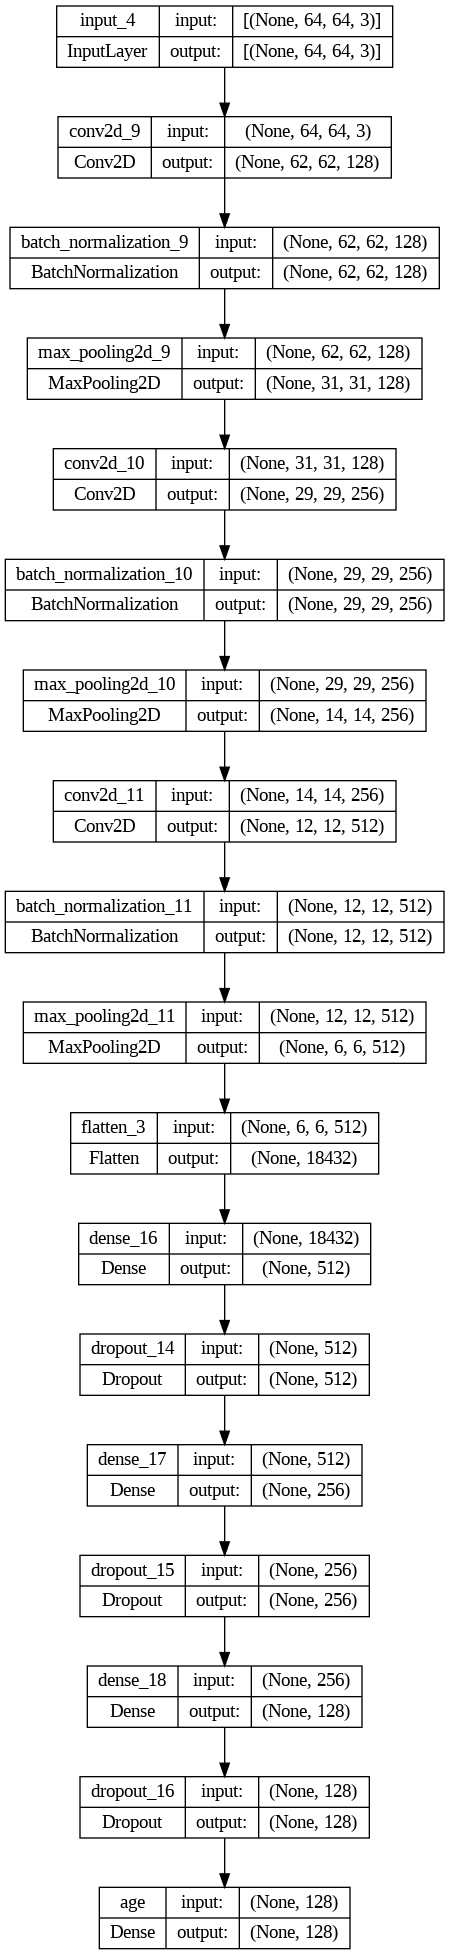

In [40]:
from tensorflow.keras.utils import plot_model
model = load_model('/content/drive/MyDrive/EECE570/Age_model_2/CNN_model_tf_multistage_race0_classification.h5')
plot_model(model, show_shapes=True)